In [ ]:
!pip install elementpath

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
keras.utils.set_random_seed(42)

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('key')
os.environ["KAGGLE_USERNAME"] = userdata.get('username')

In [ ]:
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection

Dataset URL: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection
License(s): CC0-1.0
fruit-images-for-object-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
!unzip /content/fruit-images-for-object-detection.zip -d /content/data

Archive:  /content/fruit-images-for-object-detection.zip
replace /content/data/test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import xml.etree.ElementTree as ET
def load_annotation(file,w,h,width,height):

  file=file.replace(".jpg",".xml")
  root = ET.parse(file)
  annots=[]

  for obj in root.findall('object'):
    label = int(obj.find('truncated').text)
    bndbox = obj.find('bndbox')
    xmin = int((int(bndbox.find('xmin').text)/w)*width)
    ymin = int((int(bndbox.find('ymin').text)/h)*height)
    xmax = int((int(bndbox.find('xmax').text)/w)*width)
    ymax = int((int(bndbox.find('ymax').text)/h)*height)
    annots.append([label,xmin,ymin,xmax,ymax])
  return annots

In [ ]:
def load_images_from_folder(folder):
  images=[]
  labels=[]
  for subdir, dirs, files in os.walk(folder):
    for file in files:
      path=os.path.join(subdir, file)
      if (path.endswith(".jpg")):
        img=cv2.cvtColor(cv2.imread(path,cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        labels.append(load_annotation(path,img.shape[1],img.shape[0],448,448))
        img=cv2.resize(img, (448,448))
        images.append(img)
  return  np.array(images),labels

In [ ]:
def preprocessingAnnot(labels):
  nlabels=[]
  for imgsL in labels:
    nlabel=[]
    for label in imgsL:
      xmin = label[1]
      ymin = label[2]
      xmax = label[3]
      ymax = label[4]
      xcenter=(xmin+xmax)/2
      ycenter=(ymin+ymax)/2
      w=xmax-xmin
      h=ymax-ymin
      nlabel.append([label[0],xcenter,ycenter,w,h])
    nlabels.append(nlabel)
  return nlabels

In [ ]:
def format_label(labels,cluster, grid_size=7, num_bboxes=2, num_classes=3):
    label_matrix = np.zeros((len(labels),grid_size, grid_size, num_bboxes * 5 + num_classes))
    for idx,imgsL in enumerate(labels):
      for label in imgsL:
        class_index, x_center, y_center, width, height = label
        box_index=cluster.predict(np.array([[width-x_center,height-y_center]]))[0]
        # Determine which cell the center of the box falls into
        cell_x = int(x_center //64)
        cell_y = int(y_center //64)
        # Calculate normalized positions relative to cell
        x_center = (x_center - (cell_x*64))/64
        y_center = (y_center - (cell_y*64))/64
        width = (width - (cell_x*64))/64
        height = (height - (cell_y*64))/64
        # Set class probabilities to 1 for the given class index
        label_matrix[idx,cell_y, cell_x, class_index] = 1.0
        # Set bounding box parameters for the first bounding box predictor
        bbox_index = box_index* 5
        label_matrix[idx,cell_y, cell_x, num_classes + bbox_index: num_classes + bbox_index + 4] = [x_center, y_center, width, height]
        label_matrix[idx,cell_y, cell_x, num_classes + bbox_index + 4] = 1.0  # Confidence score
    return label_matrix



In [ ]:
folder="/content/data/train_zip/train"
xTrain,yTrain=load_images_from_folder(folder)
folder="/content/data/test_zip/test"
xTest,yTest=load_images_from_folder(folder)

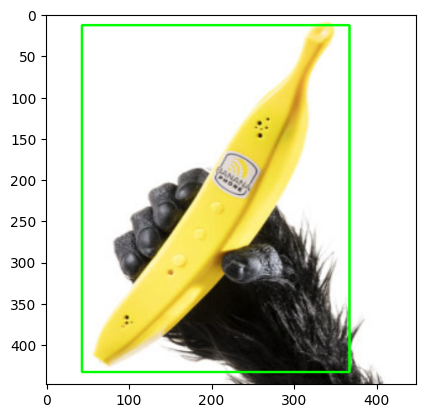

In [ ]:
idx=0
img=cv2.rectangle(xTest[idx],(yTest[idx][0][1],yTest[idx][0][2]),(yTest[idx][0][3],yTest[idx][0][4]),(0,255,0),2)
plt.imshow(img)

In [ ]:
from sklearn.cluster import KMeans
labels=preprocessingAnnot(yTrain)
data=np.array([i for x in labels for i in x])
data=data[:,3:5]-data[:,1:3]
X = data
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)

In [ ]:
y_label_matrix=preprocessingAnnot(yTest)


In [ ]:
label_matrix=format_label(labels,kmeans)

In [ ]:
y_label_matrix=format_label(y_label_matrix,kmeans)

In [ ]:
y_label_matrix.shape

(60, 7, 7, 13)

In [ ]:
label_matrix.shape

(240, 7, 7, 13)

**yolo v1**

In [ ]:
grid_size=7
num_bboxes=2
num_classes=3
output_size = grid_size * grid_size * (num_bboxes * 5 + num_classes)

In [ ]:
model=keras.Sequential([
    layers.Input(xTrain[0].shape),
    layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),

    layers.Conv2D(192, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),


    layers.Conv2D(128, (1, 1), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (1, 1), padding='same', activation='relu'),
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),


    layers.Conv2D(256, (1, 1), padding='same', activation='relu'),
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (1, 1), padding='same', activation='relu'),
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (1, 1), padding='same', activation='relu'),
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (1, 1), padding='same', activation='relu'),
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),

    layers.Conv2D(512, (1, 1), padding='same', activation='relu'),
    layers.Conv2D(1024, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    # Layers 9-10
    layers.Conv2D(512, (1, 1), padding='same', activation='relu'),
    layers.Conv2D(1024, (3, 3), padding='same', activation='relu'),
    # Layers 11-12
    layers.Conv2D(1024, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(1024, (3, 3), strides=2, padding='same', activation='relu'),
    # Layer 13-14
    layers.Conv2D(1024, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(1024, (3, 3), padding='same', activation='relu'),
    # Fully connected layers
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(output_size, activation='linear')
    ])

In [ ]:
def yolo_v1_loss(y_true, y_pred, grid_size=7, num_bboxes=2, num_classes=3, lambda_coord=5, lambda_noobj=0.2):
    S = grid_size
    B = num_bboxes
    C = num_classes
    # Reshape the predictions and true labels
    y_true = tf.reshape(y_true, (-1, S, S, C + B * 5))
    y_pred = tf.reshape(y_pred, (-1, S, S, C + B * 5))

    # Split the predictions and true labels into components
    true_classes = y_true[..., :C]
    #true_bboxes = y_true[..., C:C+B*4]
    #true_confidences = y_true[..., C+B*4:]
    true_bboxes_confidences = y_true[..., C:]




    pred_classes = y_pred[..., :C]
    #pred_bboxes = y_pred[..., C:C+B*4]
    #pred_confidences = y_pred[..., C+B*4:]

    pred_bboxes_confidences = y_pred[..., C:]

    true_bboxes_confidences= tf.reshape(true_bboxes_confidences, (-1, S, S, B, 5))
    true_bboxes=true_bboxes_confidences[...,:4]
    true_confidences = true_bboxes_confidences[...,4]


    pred_bboxes_confidences= tf.reshape(pred_bboxes_confidences, (-1, S, S, B, 5))
    pred_bboxes=pred_bboxes_confidences[...,:4]
    pred_confidences = pred_bboxes_confidences[...,4]

    # Reshape bounding boxes to (batch_size, S, S, B, 4)
    #true_bboxes = tf.reshape(true_bboxes, (-1, S, S, B, 4))
    #pred_bboxes = tf.reshape(pred_bboxes, (-1, S, S, B, 4))
    # Extract the coordinates
    true_xy = true_bboxes[..., :2]
    true_wh = true_bboxes[..., 2:4]
    pred_xy = pred_bboxes[..., :2]
    pred_wh = pred_bboxes[..., 2:4]

    # Create mask for cells containing objects
    object_mask = tf.reduce_max(true_confidences, axis=-1, keepdims=True)




    #print("object_mask= ",object_mask.shape)
    #print("true_xy ",true_xy.shape)
    #print("tf.square(true_xy - pred_xy)= ",tf.square(true_xy - pred_xy).shape)
    #print("tf.reduce_sum(tf.square(true_xy - pred_xy) + tf.square(true_wh - pred_wh), axis=-1)= ",tf.reduce_sum(tf.square(true_xy - pred_xy) + tf.square(true_wh - pred_wh), axis=-1).shape)
    # Localization loss
    coord_loss = tf.reduce_sum(lambda_coord * object_mask * tf.reduce_sum(tf.square(true_xy - pred_xy) + tf.square(true_wh - pred_wh), axis=-1), axis=-1, keepdims=True)



    #print("object_mask= ",object_mask.shape)
    #print("tf.square(true_confidences - pred_confidences) ",tf.square(true_confidences - pred_confidences).shape)
    # Confidence loss
    confidence_loss = tf.reduce_sum(object_mask * tf.square(true_confidences - pred_confidences) +

              lambda_noobj * (1 - object_mask) * tf.square(true_confidences - pred_confidences), axis=-1, keepdims=True)

    # Classification loss
    class_loss = object_mask * tf.reduce_sum(tf.square(true_classes - pred_classes), axis=-1, keepdims=True)
    #print("coord_loss ",coord_loss.shape)
    #print("confidence_loss ",confidence_loss.shape)
    #print("class_loss ",class_loss.shape)
    # Total loss
    total_loss = coord_loss + confidence_loss + class_loss
    return tf.reduce_mean(total_loss)


In [ ]:
# Custom loss needs to be passed as a function with appropriate arguments
def custom_yolo_loss(y_true, y_pred):
    return yolo_v1_loss(y_true, y_pred)

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=custom_yolo_loss)


In [ ]:
his=model.fit(xTrain,label_matrix, epochs=100, batch_size=64, validation_split=0.1)

Epoch 1/100
4/4 [==============================] - 4s 847ms/step - loss: 0.5835 - val_loss: 0.5997
Epoch 2/100
4/4 [==============================] - 3s 828ms/step - loss: 0.5609 - val_loss: 0.6180
Epoch 3/100
4/4 [==============================] - 3s 835ms/step - loss: 0.5573 - val_loss: 0.6250
Epoch 4/100
4/4 [==============================] - 3s 844ms/step - loss: 0.5762 - val_loss: 0.6106
Epoch 5/100
4/4 [==============================] - 4s 852ms/step - loss: 0.5692 - val_loss: 0.5983
Epoch 6/100
4/4 [==============================] - 3s 844ms/step - loss: 0.5687 - val_loss: 0.6037
Epoch 7/100
4/4 [==============================] - 3s 847ms/step - loss: 0.5642 - val_loss: 0.6164
Epoch 8/100
4/4 [==============================] - 4s 855ms/step - loss: 0.5751 - val_loss: 0.5850
Epoch 9/100
4/4 [==============================] - 4s 867ms/step - loss: 0.5361 - val_loss: 0.5587
Epoch 10/100
4/4 [==============================] - 4s 863ms/step - loss: 0.5255 - val_loss: 0.5468
Epoch 11/

KeyboardInterrupt: 

In [ ]:
img=xTrain[1:2]
img.shape

(1, 448, 448, 3)

In [ ]:
result=model.predict(img)

1/1 [==============================] - 0s 24ms/step


In [ ]:
result=result.reshape((-1, 7, 7, 3 + 2 * 5))

In [ ]:
label_matrix[1,4,3,-1]

1.0

In [ ]:
result[0,:,:,7]

array([[-0.03075463,  0.04973889, -0.04899548,  0.02346393, -0.00802268,
        -0.02942455, -0.01371512],
       [ 0.01622634, -0.02661571,  0.12352329, -0.00806383, -0.08234163,
        -0.01724073, -0.04101165],
       [ 0.02023191, -0.00583214,  0.14444137,  0.00940308,  0.13346228,
        -0.01587848, -0.04274273],
       [-0.05086558,  0.00311037,  0.06805436,  0.06645299,  0.31183276,
        -0.02864012, -0.03132236],
       [-0.00826142,  0.14822887, -0.06268962,  0.05268964,  0.22337092,
        -0.00064275, -0.06248981],
       [ 0.00957543,  0.00832836, -0.0991706 , -0.03757896, -0.01508095,
        -0.07252394, -0.00326564],
       [-0.04372436, -0.0147239 , -0.00163296,  0.0419111 , -0.0034558 ,
        -0.03574415, -0.02766879]], dtype=float32)

In [ ]:
np.set_printoptions(suppress=True)


In [ ]:
result[0,:,:,-1]

array([[ 0.00114163, -0.02609242,  0.00912872, -0.01509761, -0.0019666 ,
         0.01315267, -0.02292046],
       [-0.00328371, -0.03431936,  0.03300652, -0.02316956,  0.0098641 ,
         0.0310667 , -0.01663042],
       [-0.0396033 , -0.01150936, -0.00674094,  0.07060646, -0.05709134,
        -0.04133639, -0.0102655 ],
       [ 0.02576172,  0.04560898,  0.16656552,  0.83265084, -0.13224092,
         0.00984237,  0.02439748],
       [ 0.02835756, -0.02591792,  0.26146793,  0.66253316, -0.09669646,
        -0.01403403, -0.04583329],
       [-0.03847427,  0.00297769, -0.03205549, -0.00048088, -0.03596113,
        -0.01909255, -0.03688045],
       [ 0.01951794,  0.00992551, -0.02093561, -0.04337039, -0.01753186,
        -0.00334678,  0.01153071]], dtype=float32)

In [ ]:
result[0,4,3,-1]

0.44264987

In [ ]:
xTest.shape

(60, 448, 448, 3)

In [ ]:
y_label_matrix.shape

(60, 7, 7, 13)

In [ ]:
img=xTest[0:1]
img.shape

(1, 448, 448, 3)

In [ ]:
result=model.predict(img)

1/1 [==============================] - 0s 31ms/step


In [ ]:
y_label_matrix[0,:,:,7]

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
result=result.reshape((-1, 7, 7, 3 + 2 * 5))

In [ ]:
result[0,:,:,7]

array([[-0.00225488,  0.05149531, -0.0011525 ,  0.02435442, -0.0302121 ,
        -0.01886898, -0.02681588],
       [ 0.02969922,  0.01279299, -0.11194897,  0.09905829,  0.02807072,
         0.07158273, -0.03825439],
       [ 0.03598055,  0.01920051,  0.01576844, -0.06735593,  0.09988397,
        -0.11631323, -0.04353357],
       [ 0.04915869,  0.01902058,  0.01269276,  0.06387189,  0.13433133,
        -0.0488569 , -0.02175352],
       [ 0.00522646, -0.14662963,  0.13698253, -0.02400285,  0.06320751,
         0.06400158, -0.04653298],
       [-0.06251127, -0.05932637,  0.05028813, -0.02636742,  0.01372141,
         0.03019177, -0.04522865],
       [ 0.02630719, -0.01307722, -0.02047982, -0.03345193,  0.0121806 ,
        -0.03881569, -0.02836746]], dtype=float32)